<a href="https://colab.research.google.com/github/jonesLevin/Data-Science-Competitions/blob/main/CIBMTR_Equity_in_post_HCT_Survival_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Equity in post-HCT Survival Predictions

Improve prediction of transplant survival rates equitably for allogeneic HCT patients

In [2]:
!unzip equity-post-HCT-survival-predictions.zip

Archive:  equity-post-HCT-survival-predictions.zip
  inflating: test.csv                
  inflating: data_dictionary.csv     
  inflating: sample_submission.csv   
  inflating: train.csv               


In [8]:
!pip install -q lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 11.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=f37f8cc5c78dbb29f0f3b0cb4ac190535232ab1346658d9396416c1f2055e2cb
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


# Load train and test sets

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape)
print(test.shape)

train.head()

(28800, 60)
(3, 58)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


## EDA on Train Targets

There are two targets *efs* and *efs_time*. When *efs==1* we know that the patients did not survive and the time of death is *efs_time*. When *efs==0* we **do no know** if the patient survived or not, but we know that the patient survived for atleast *efs_time*

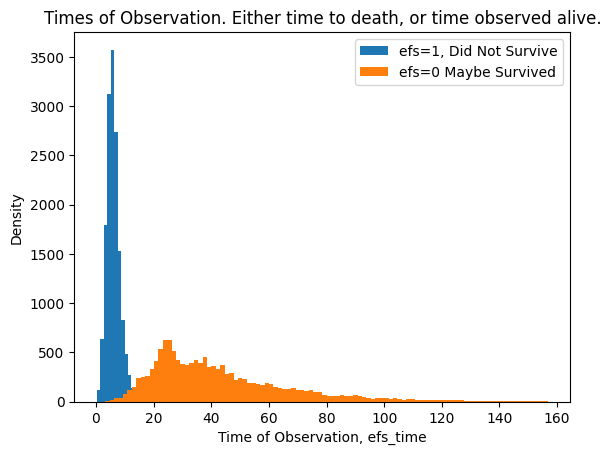

In [7]:
plt.hist(train.loc[train['efs'] == 1, 'efs_time'], bins=100, label='efs=1, Did Not Survive')
plt.hist(train.loc[train['efs'] == 0, 'efs_time'], bins=100, label='efs=0 Maybe Survived')
plt.xlabel('Time of Observation, efs_time')
plt.ylabel('Density')
plt.title('Times of Observation. Either time to death, or time observed alive.')
plt.legend()
plt.show()

## Transform the Two Train Targets into One

Both targets efs and efs_time provide useful information. We will tranform these two targets into a single target to train our model with

In [9]:
from lifelines import KaplanMeierFitter

def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
  """
  Transform using survival probability estimates
  """
  kmf = KaplanMeierFitter()
  kmf.fit(df[time_col], df[event_col])

  # Get survival probabilities at each time point
  return kmf.survival_function_at_times(df[time_col]).values

In [10]:
train["y"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')

In [11]:
train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,y
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356,0.458687
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672,0.847759
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793,0.462424
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349,0.456661
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223,0.464674


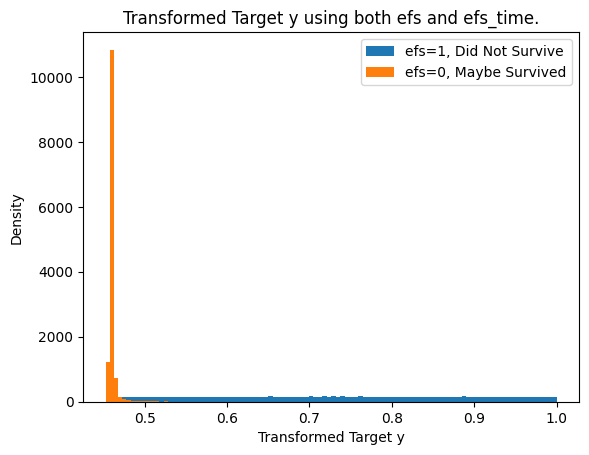

In [12]:
plt.hist(train.loc[train['efs'] == 1,"y"], bins=100, label="efs=1, Did Not Survive")
plt.hist(train.loc[train['efs'] == 0, "y"], bins=100, label="efs=0, Maybe Survived")
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

## Feature Engineering

In [13]:
DROP = ["ID", "efs", "efs_time", "y"]
FEATURES = [c for c in train.columns if c not in DROP]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [14]:
hct_ci_mapping = {
    "arrhythmia": {"No": 0, "Not done": 0, "Yes": 1},
    "cardiac": {"No": 0, "Not done": 0, "Yes": 1},
    "diabetes": {"No": 0, "Not done": 0, "Yes": 1},
    "hepatic_mild": {"No": 0, "Not done": 0, "Yes": 1},
    "hepatic_severe": {"No": 0, "Not done": 0, "Yes": 3},
    "psych_disturb": {"No": 0, "Not done": 0, "Yes": 1},
    "obesity": {"No": 0, "Not done": 0, "Yes": 1},
    "rheum_issue": {"No": 0, "Not done": 0, "Yes": 2},
    "peptic_ulcer": {"No": 0, "Not done": 0, "Yes": 2},
    "renal_issue": {"No": 0, "Not done": 0, "Yes": 2},
    "prior_tumor": {"No": 0, "Not done": 0, "Yes": 3},
    "pulm_moderate": {"No": 0, "Not done": 0, "Yes": 2},
    "pulm_severe": {"No": 0, "Not done": 0, "Yes": 3},
}

def calculate_hct_ci_score(row, mapping):
  """
  This function calculates the hct_ci score

  Args:
    row (pd.Series): Patient Clinical Data
    mapping (dict): HCT-CI score mapping

  Returns:
    int: HCT-CI score
  """

  score = 0

  if "hepatic_severe" in row and row["hepatic_severe"] == "Yes":
    score += mapping["hepatic_severe"]["Yes"]
  elif "hepatic_mild" in row and row["hepatic_mild"] == "Yes":
    score += mapping["hepatic_mild"]["Yes"]

  if "pulm_moderate" in row and row["pulm_moderate"] == "Yes":
    score += mapping["pulm_moderate"]["Yes"]
  elif "pulm_severe" in row and row["pulm_severe"] == "Yes":
    score += mapping["pulm_severe"]["Yes"]

  for condition, mapping_values in mapping.items():
    if condition not in ["hepatic_mild", "hepatic_severe","pulm_moderate", "pulm_severe"] and condition in row:
      score += mapping_values.get(row[condition], 0)

  return score

In [15]:
# Convert categorical features into numerical features
def cat2num(df: pd.DataFrame):
  df['conditioning_intensity'] = df['conditioning_intensity'].map({
      'NMA': 1,
      'RIC': 2,
      'MAC': 3,
      'TBD': None,
      'No drugs reported': None,
      'N/A, F(pre-TED) not submitted': None})

  df['tbi_status'] = df['tbi_status'].map({
      'No TBI': 0,
      'TBI +- Other, <=cGy': 1,
      'TBI +- Other, -cGy, fractionated': 2,
      'TBI + Cy +- Other': 3,
      'TBI +- Other, -cGy, single': 4,
      'TBI +- Other, >cGy': 5,
      'TBI +- Other, unknown dose': None})

  df['dri_score'] = df['dri_score'].map({
      'Low': 1,
      'Intermediate': 2,
      'Intermediate - TED AML case <missing cytogenetics': 3,
      'High': 4,
      'High - TED AML case <missing cytogenetics': 5,
      'Very High': 6,
      'N/A - pediatric': -3,
      'N/A - non-malignant indication': -1,
      'TBD cytogenetics': -2,
      'N/A - disease not classifiable': -4,
      'Missing disease status': 0})

  df['cyto_score'] = df['cyto_score'].map({
      'Poor': 4,
      'Normal': 3,
      'Intermediate': 2,
      'Favorable': 1,
      'TBD': -1,
      'Other': -2,
      'Not tested': None})

  df['cyto_score_detail'] = df['cyto_score_detail'].map({
      'Poor': 3,
      'Intermediate': 2,
      'Favorable': 1,
      'TBD': -1,
      'Not tested': None})

  return df

In [16]:
def fill_hla_combined_low(row):
  if np.isnan(row['hla_combined_low']):
    components = [
        row['hla_match_drb1_low'], row['hla_match_dqb1_low'],
        row['hla_match_a_low'], row['hla_match_b_low'], row['hla_match_c_low']
        ]

    if all([not np.isnan(x) for x in components]): return sum(components)
    else:
      if not np.isnan(row['hla_low_res_8']) and not np.isnan(row['hla_match_dqb1_low']):
        return row['hla_low_res_8'] + row['hla_match_dqb1_low']
      elif not np.isnan(row['hla_low_res_6']):
        components_6 = [
            row['hla_match_dqb1_low'], row['hla_match_c_low']
            ]
        if all([not np.isnan(x) for x in components_6]): return row['hla_low_res_6'] + sum(components_6)
        else: return sum([x for x in components if not np.isnan(x)])
  return row['hla_combined_low']


In [17]:
def add_features(df):
  df["hct_ci_score"] = df.apply(lambda row: calculate_hct_ci_score(row, hct_ci_mapping), axis=1)
  df['donor_recipient_age_diff'] = abs(df['donor_age'] - df['age_at_hct'])

  df = cat2num(df)

  df['hla_combined_low'] = df['hla_low_res_10']
  df['hla_combined_low'] = df.apply(fill_hla_combined_low, axis=1)
  df['hla_match_ratio'] = (df['hla_high_res_8'] + df['hla_low_res_8']) / 16
  df['years_since_2000'] = df['year_hct'] - 2000
  df['null_count'] = df.isnull().sum(axis=1)
  df['ci_score_danger'] = df['hct_ci_score'].apply(lambda x: 2 if x >= 3 else 1 if x >= 1 else 0)

  return df

In [18]:
train = add_features(train)
test = add_features(test)

In [19]:
train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,y,hct_ci_score,donor_recipient_age_diff,hla_combined_low,hla_match_ratio,years_since_2000,null_count,ci_score_danger
0,0,-1.0,No,NaN,No,NaN,NaN,0.0,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356,0.458687,0,NaN,10.0,NaN,16,13,0
1,1,2.0,No,2.0,No,2.0,8.0,5.0,No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,2.0,3.0,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672,0.847759,2,28.585,10.0,1.0,8,0,1
2,2,-1.0,No,NaN,No,2.0,8.0,0.0,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793,0.462424,0,NaN,10.0,1.0,19,7,0
3,3,4.0,No,2.0,No,2.0,8.0,0.0,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,2.0,3.0,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349,0.456661,1,14.015,10.0,1.0,9,0,1
4,4,4.0,No,NaN,No,2.0,8.0,0.0,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,3.0,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223,0.464674,0,27.070,10.0,1.0,18,5,0


In [20]:
CATS = []
for c in FEATURES:
  if train[c].dtype=="object":
    CATS.append(c)
    train[c] = train[c].fillna("NAN")
    test[c] = test[c].fillna("NAN")

print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 30 CATEGORICAL FEATURES: ['psych_disturb', 'diabetes', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [21]:
combined = pd.concat([train,test],axis=0,ignore_index=True)

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
  if c in CATS:
    print(f"{c}, ",end="")
    combined[c],_ = combined[c].factorize()
    combined[c] -= combined[c].min()
    combined[c] = combined[c].astype("int32")
    combined[c] = combined[c].astype("category")

  # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
  else:
    if combined[c].dtype=="float64":
      combined[c] = combined[c].astype("float32")
    if combined[c].dtype=="int64":
      combined[c] = combined[c].astype("int32")

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: psych_disturb, diabetes, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [22]:
FEATURES += ["hct_ci_score", 'donor_recipient_age_diff', "hla_combined_low", "hla_match_ratio",
             "years_since_2000", "null_count","ci_score_danger"]

In [23]:
train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,y,hct_ci_score,donor_recipient_age_diff,hla_combined_low,hla_match_ratio,years_since_2000,null_count,ci_score_danger
0,0,-1.0,0,NaN,0,NaN,NaN,0.0,0,6.0,0,0,0,0,0,6.0,0,NaN,2.0,0,6.0,2.0,0,2.0,2.0,0,NaN,NaN,0,2016,0,0,0,0,2.0,0,NaN,0,2.0,0,9.942000,2.0,0,0,0,2.0,0,0.0,90.0,0,0,0,0,8.0,0,2.0,0,10.0,0.0,42.356,0.458687,0,NaN,10.0,NaN,16,13,0
1,1,2.0,0,2.0,0,2.0,8.0,5.0,0,6.0,1,0,0,0,1,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,1,2.0,3.0,0,2008,0,1,1,1,2.0,0,72.290001,0,2.0,0,43.705002,2.0,1,0,1,2.0,1,3.0,90.0,0,1,1,0,8.0,0,2.0,1,10.0,1.0,4.672,0.847759,2,28.585,10.0,1.0,8,0,1
2,2,-1.0,0,NaN,0,2.0,8.0,0.0,0,6.0,0,0,0,0,2,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,0,NaN,NaN,0,2019,0,0,0,0,2.0,0,NaN,0,2.0,0,33.997002,2.0,2,0,2,2.0,0,0.0,90.0,0,1,1,0,8.0,0,2.0,0,10.0,0.0,19.793,0.462424,0,NaN,10.0,1.0,19,7,0
3,3,4.0,0,2.0,0,2.0,8.0,0.0,0,6.0,0,0,0,0,3,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,0,2.0,3.0,0,2009,0,1,1,1,2.0,0,29.230000,0,2.0,0,43.244999,2.0,3,0,3,2.0,2,0.0,90.0,1,1,0,0,8.0,0,2.0,0,10.0,0.0,102.349,0.456661,1,14.015,10.0,1.0,9,0,1
4,4,4.0,0,NaN,0,2.0,8.0,0.0,0,6.0,1,0,0,0,4,6.0,0,10.0,2.0,0,5.0,2.0,0,2.0,2.0,1,NaN,3.0,1,2018,0,0,0,0,2.0,0,56.810001,0,2.0,0,29.740000,2.0,4,0,0,2.0,3,1.0,90.0,0,1,1,1,8.0,0,2.0,0,10.0,0.0,16.223,0.464674,0,27.070,10.0,1.0,18,5,0


## XGBoost Classifier

In [24]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost
print("Using XGBoost version",xgboost.__version__)

Using XGBoost version 2.1.3


In [25]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [26]:
FOLDS = 5
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb = np.zeros(len(train))
pred_efs = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train, train["efs"])):
  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, "efs"]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, "efs"]
  x_test = test[FEATURES].copy()

  model_xgb = XGBClassifier(
      device="cuda",
      max_depth=6,
      colsample_bytree=0.7,
      subsample=0.8,
      n_estimators=20_000,
      learning_rate=0.01,
      eval_metric="auc",
      early_stopping_rounds=50,
      objective='binary:logistic',
      scale_pos_weight=1,
      min_child_weight=3,
      enable_categorical=True,
      gamma=1
  )

  model_xgb.fit(
      x_train, y_train,
      eval_set=[(x_valid, y_valid)],
      verbose=100
  )

  # INFER OOF (Probabilities -> Binary)
  oof_xgb[test_index] = (model_xgb.predict_proba(x_valid)[:, 1] > 0.5).astype(int)
  # INFER TEST (Probabilities -> Average Probs)
  pred_efs += model_xgb.predict_proba(x_test)[:, 1]

  # COMPUTE AVERAGE TEST PREDS
pred_efs = (pred_efs / FOLDS > 0.5).astype(int)

# EVALUATE PERFORMANCE
accuracy = accuracy_score(train["efs"], oof_xgb)
f1 = f1_score(train["efs"], oof_xgb)
roc_auc = roc_auc_score(train["efs"], oof_xgb)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

#########################
### Fold 1
#########################
[0]	validation_0-auc:0.67081
[100]	validation_0-auc:0.71714
[200]	validation_0-auc:0.72410
[300]	validation_0-auc:0.72907
[400]	validation_0-auc:0.73279
[500]	validation_0-auc:0.73598
[600]	validation_0-auc:0.73780
[700]	validation_0-auc:0.73905
[800]	validation_0-auc:0.74001
[900]	validation_0-auc:0.74047
[1000]	validation_0-auc:0.74091
[1100]	validation_0-auc:0.74113
[1138]	validation_0-auc:0.74122
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:26:50] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.69435
[100]	validation_0-auc:0.73944
[200]	validation_0-auc:0.74770
[300]	validation_0-auc:0.75251
[400]	validation_0-auc:0.75522
[500]	validation_0-auc:0.75735
[600]	validation_0-auc:0.75849
[700]	validation_0-auc:0.75921
[800]	validation_0-auc:0.75997
[900]	validation_0-auc:0.76064
[1000]	validation_0-auc:0.76116
[1100]	validation_0-auc:0.76153
[1200]	validation_0-auc:0.76182
[1224]	validation_0-auc:0.76188
#########################
### Fold 3
#########################
[0]	validation_0-auc:0.68541
[100]	validation_0-auc:0.73838
[200]	validation_0-auc:0.74501
[300]	validation_0-auc:0.74918
[400]	validation_0-auc:0.75300
[500]	validation_0-auc:0.75568
[600]	validation_0-auc:0.75733
[700]	validation_0-auc:0.75845
[800]	validation_0-auc:0.75925
[900]	validation_0-auc:0.75971
[998]	validation_0-auc:0.75957
#########################
### Fold 4
#########################
[0]	validation_0-auc:0.68828
[100]	validation_0-auc:0.73359
[200]	validation_0-auc:0.74218
[300]	va

In [27]:
bin_pred = oof_xgb
bin_pred

array([0., 1., 0., ..., 1., 0., 0.])

In [28]:
pred_classifier = pred_efs
pred_classifier

array([0, 1, 0])

## XGBoost Regressor

In [29]:
%%time
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):
  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, "y"]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, "y"]
  x_test = test[FEATURES].copy()

  model_xgb = XGBRegressor(
      device="cuda",
      max_depth=4,
      colsample_bytree=0.5,
      subsample=0.8,
      n_estimators=10_000,
      learning_rate=0.05,
      eval_metric="mae",
      early_stopping_rounds=25,
      objective='reg:logistic',
      enable_categorical=True,
      min_child_weight=5
  )

  model_xgb.fit(
      x_train, y_train,
      eval_set=[(x_valid, y_valid)],
      verbose=100
  )

  # INFER OOF
  oof_xgb[test_index] = model_xgb.predict(x_valid)
  # INFER TEST
  pred_xgb += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-mae:0.15396
[100]	validation_0-mae:0.13493
[200]	validation_0-mae:0.13151
[300]	validation_0-mae:0.12979
[400]	validation_0-mae:0.12882
[500]	validation_0-mae:0.12823
[600]	validation_0-mae:0.12788
[700]	validation_0-mae:0.12754
[800]	validation_0-mae:0.12729
[900]	validation_0-mae:0.12701
[935]	validation_0-mae:0.12705
#########################
### Fold 2
#########################
[0]	validation_0-mae:0.15524
[100]	validation_0-mae:0.13598
[200]	validation_0-mae:0.13243
[300]	validation_0-mae:0.13073
[400]	validation_0-mae:0.12966
[500]	validation_0-mae:0.12914
[600]	validation_0-mae:0.12861
[700]	validation_0-mae:0.12834
[800]	validation_0-mae:0.12812
[866]	validation_0-mae:0.12804
#########################
### Fold 3
#########################
[0]	validation_0-mae:0.15384
[100]	validation_0-mae:0.13449
[200]	validation_0-mae:0.13086
[300]	validation_0-mae:0.12915
[400]	validation_0-mae:0.12810
[500]	valid

In [30]:
oof_xgb

array([0.48681369, 0.63909513, 0.42267537, ..., 0.68188161, 0.5764882 ,
       0.4974876 ])

In [31]:
pred_xgb

array([0.48946857, 0.6732602 , 0.42893084])

In [32]:
bin_pred_np = np.array(bin_pred)
oof_xgb_np = np.array(oof_xgb)

combined_array = np.column_stack((bin_pred_np, oof_xgb_np))

print(combined_array)

[[0.         0.48681369]
 [1.         0.63909513]
 [0.         0.42267537]
 ...
 [1.         0.68188161]
 [0.         0.5764882 ]
 [0.         0.4974876 ]]


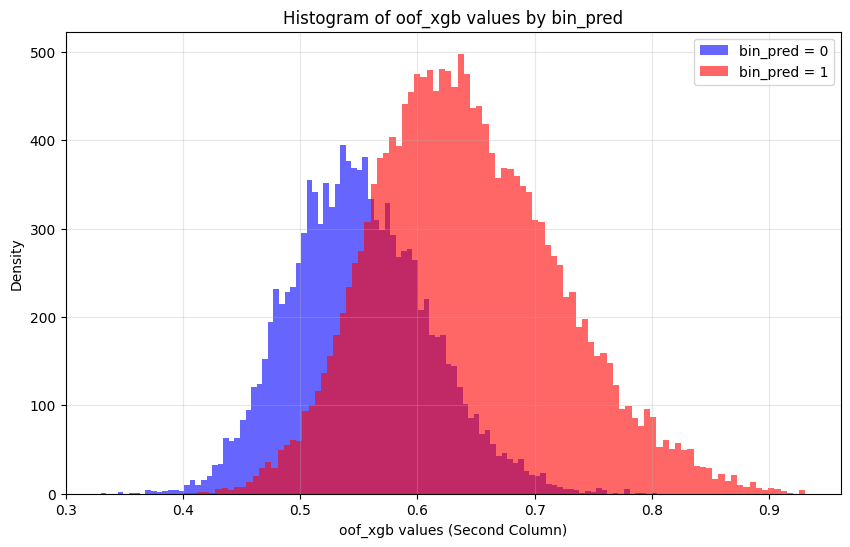

In [33]:
data_0 = combined_array[combined_array[:, 0] == 0]
data_1 = combined_array[combined_array[:, 0] == 1]


plt.figure(figsize=(10, 6))
plt.hist(data_0[:, 1], bins=100, color='blue', alpha=0.6, label='bin_pred = 0')
plt.hist(data_1[:, 1], bins=100, color='red', alpha=0.6, label='bin_pred = 1')

plt.xlabel('oof_xgb values (Second Column)')
plt.ylabel('Density')
plt.title('Histogram of oof_xgb values by bin_pred')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [34]:
combined_array[combined_array[:, 0] == 1, 1] += 0.1

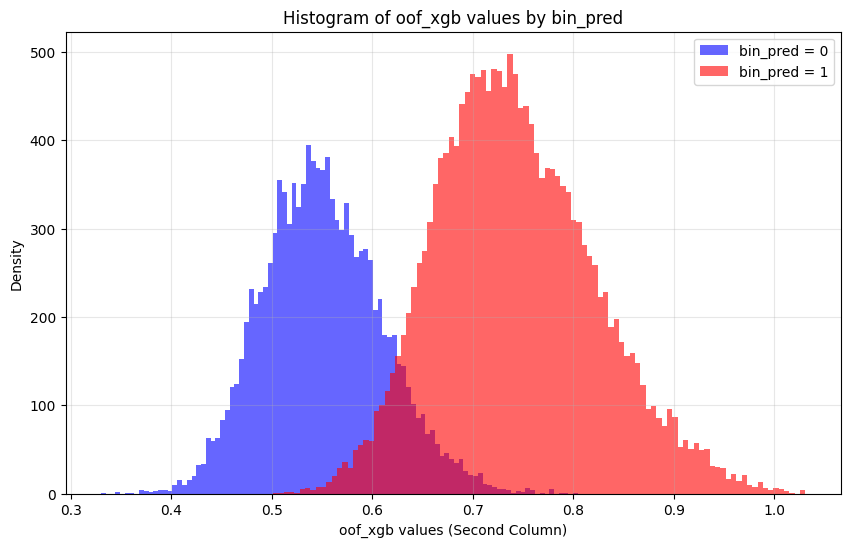

In [35]:
data_0 = combined_array[combined_array[:, 0] == 0]
data_1 = combined_array[combined_array[:, 0] == 1]

plt.figure(figsize=(10, 6))

plt.hist(data_0[:, 1], bins=100, color='blue', alpha=0.6, label='bin_pred = 0')

plt.hist(data_1[:, 1], bins=100, color='red', alpha=0.6, label='bin_pred = 1')

plt.xlabel('oof_xgb values (Second Column)')
plt.ylabel('Density')
plt.title('Histogram of oof_xgb values by bin_pred')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [36]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = combined_array[:, 1]

print(y_pred)

          ID  prediction
0          0    0.486814
1          1    0.739095
2          2    0.422675
3          3    0.761050
4          4    0.604946
...      ...         ...
28795  28795    0.527315
28796  28796    0.817361
28797  28797    0.781882
28798  28798    0.576488
28799  28799    0.497488

[28800 rows x 2 columns]


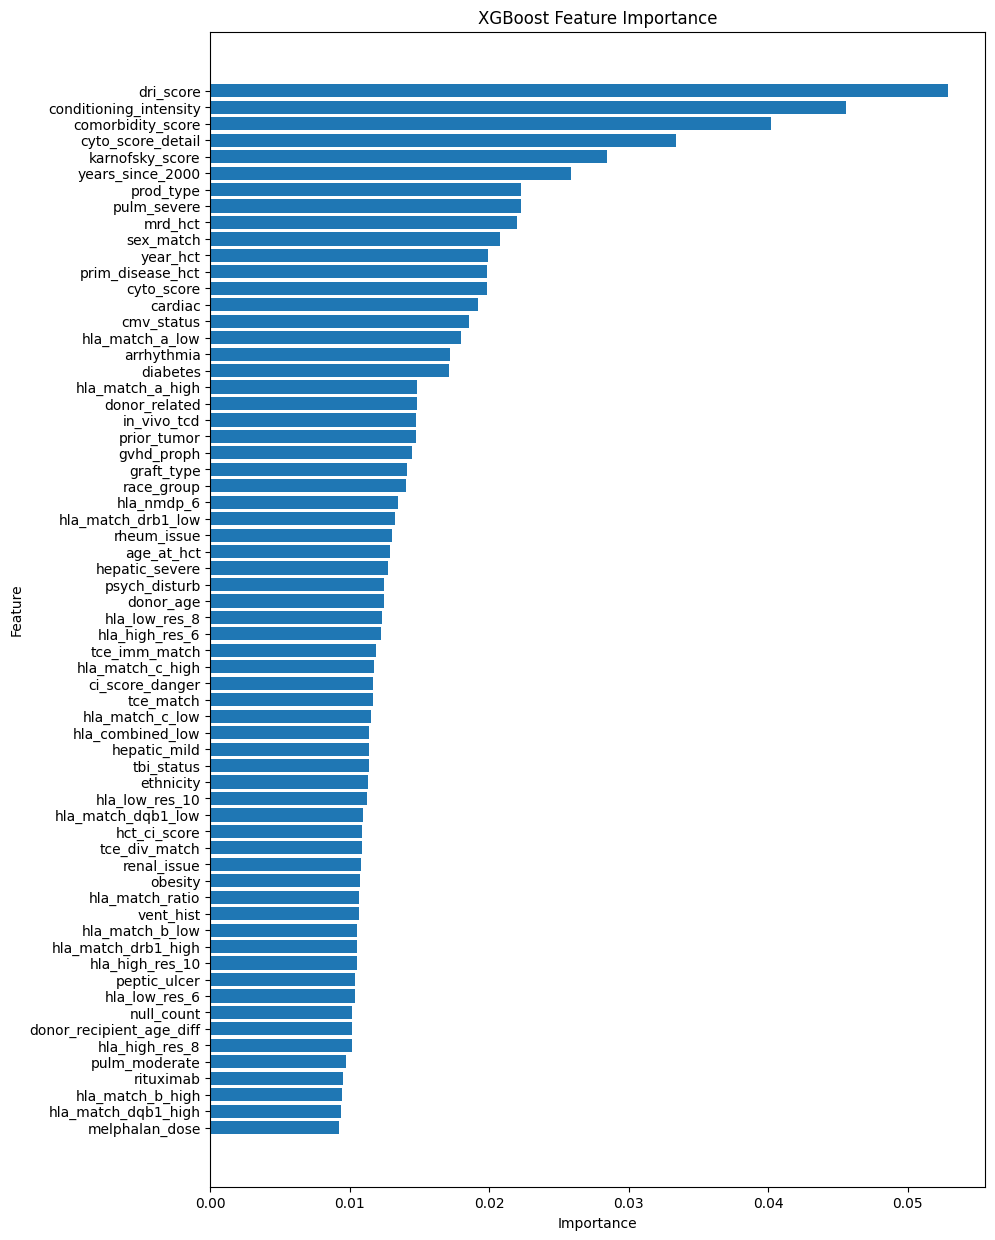

In [40]:
feature_importance = model_xgb.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  # Replace FEATURES with your list of feature names
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

## CatBoost

In [42]:
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.9 MB/s eta 0:00:00


In [43]:
from catboost import CatBoostRegressor, CatBoostClassifier
import catboost
print("Using CatBoost version",catboost.__version__)

Using CatBoost version 1.2.7


In [44]:
%%time
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat = np.zeros(len(train))
pred_cat = np.zeros(len(test))

cat_params = {
    "iterations": 1000,
    "depth": 6,
    "learning_rate": 0.2,
    "l2_leaf_reg": 5,
    "random_seed": 42,
    "task_type": "CPU",
    "verbose": 100
}

for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  x_train = train.loc[train_index,FEATURES].copy()
  y_train = train.loc[train_index,"y"]
  x_valid = train.loc[test_index,FEATURES].copy()
  y_valid = train.loc[test_index,"y"]
  x_test = test[FEATURES].copy()

  model_cat = CatBoostRegressor(**cat_params, cat_features=CATS)
  model_cat.fit(
      x_train,
      y_train,
      eval_set=(x_valid, y_valid),
  )

  # INFER OOF
  oof_cat[test_index] = model_cat.predict(x_valid)
  # INFER TEST
  pred_cat += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.1736528	test: 0.1728237	best: 0.1728237 (0)	total: 233ms	remaining: 3m 52s
100:	learn: 0.1517362	test: 0.1568583	best: 0.1568583 (100)	total: 12.4s	remaining: 1m 50s
200:	learn: 0.1463981	test: 0.1560649	best: 0.1560416 (197)	total: 23.9s	remaining: 1m 34s
300:	learn: 0.1421081	test: 0.1555952	best: 0.1555808 (295)	total: 36.9s	remaining: 1m 25s
400:	learn: 0.1391483	test: 0.1556127	best: 0.1555808 (295)	total: 50.6s	remaining: 1m 15s
500:	learn: 0.1363291	test: 0.1555111	best: 0.1554926 (493)	total: 1m 6s	remaining: 1m 6s
600:	learn: 0.1337275	test: 0.1554925	best: 0.1554347 (519)	total: 1m 18s	remaining: 51.9s
700:	learn: 0.1311837	test: 0.1556139	best: 0.1554270 (631)	total: 1m 29s	remaining: 38.3s
800:	learn: 0.1284520	test: 0.1557377	best: 0.1554270 (631)	total: 1m 41s	remaining: 25.2s
900:	learn: 0.1264829	test: 0.1559235	best: 0.1554270 (631)	total: 1m 52s	remaining: 12.4s
999:	learn: 0.1243884	test: 0.15

In [45]:
bin_pred_np = np.array(bin_pred)
oof_cat_np = np.array(oof_cat)

combined_array_cat = np.column_stack((bin_pred_np, oof_cat_np))

print(combined_array)

[[0.         0.48681369]
 [1.         0.73909513]
 [0.         0.42267537]
 ...
 [1.         0.78188161]
 [0.         0.5764882 ]
 [0.         0.4974876 ]]


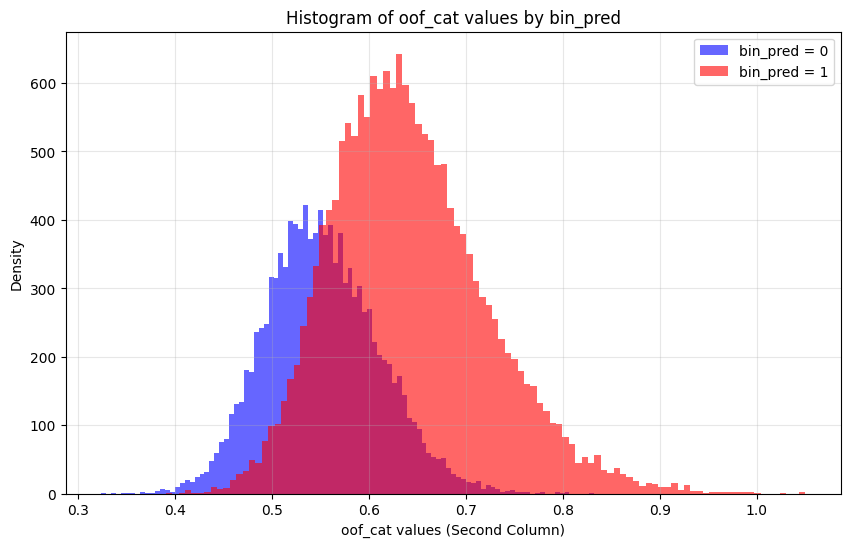

In [46]:
data_0 = combined_array_cat[combined_array_cat[:, 0] == 0]
data_1 = combined_array_cat[combined_array_cat[:, 0] == 1]

plt.figure(figsize=(10, 6))

plt.hist(data_0[:, 1], bins=100, color='blue', alpha=0.6, label='bin_pred = 0')

plt.hist(data_1[:, 1], bins=100, color='red', alpha=0.6, label='bin_pred = 1')

plt.xlabel('oof_cat values (Second Column)')
plt.ylabel('Density')
plt.title('Histogram of oof_cat values by bin_pred')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [47]:
combined_array_cat[combined_array_cat[:, 0] == 1, 1] += 0.1

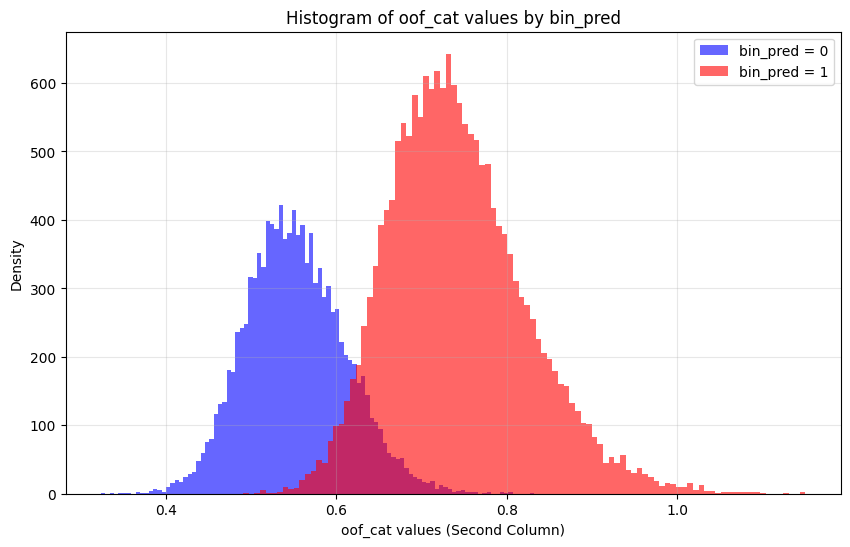

In [48]:
data_0 = combined_array_cat[combined_array_cat[:, 0] == 0]
data_1 = combined_array_cat[combined_array_cat[:, 0] == 1]

plt.figure(figsize=(10, 6))

plt.hist(data_0[:, 1], bins=100, color='blue', alpha=0.6, label='bin_pred = 0')

plt.hist(data_1[:, 1], bins=100, color='red', alpha=0.6, label='bin_pred = 1')

plt.xlabel('oof_cat values (Second Column)')
plt.ylabel('Density')
plt.title('Histogram of oof_cat values by bin_pred')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [49]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = combined_array_cat[:, 1]

print(y_pred)

          ID  prediction
0          0    0.471239
1          1    0.751961
2          2    0.437788
3          3    0.785112
4          4    0.625270
...      ...         ...
28795  28795    0.553356
28796  28796    0.831201
28797  28797    0.777911
28798  28798    0.572757
28799  28799    0.486850

[28800 rows x 2 columns]


## Ensemble CAT and XGB

In [50]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = combined_array[:, 1] + combined_array_cat[:, 1]

## Create Submission CSV

In [52]:
prediction = pred_xgb + pred_cat

pred_classifier_np = np.array(pred_classifier)
prediction_np = np.array(prediction)

combined_pred = np.column_stack((pred_classifier_np, prediction_np))
print(combined_pred)  # (2, 3)

combined_pred[combined_pred[:, 0] == 1, 1] += 0.1
print(combined_pred)  # (2, 3)


sub = pd.read_csv("sample_submission.csv")
sub.prediction = combined_pred[:, 1]

print(sub)

[[0.         0.97343191]
 [1.         1.38441396]
 [0.         0.87692277]]
[[0.         0.97343191]
 [1.         1.48441396]
 [0.         0.87692277]]
      ID  prediction
0  28800    0.973432
1  28801    1.484414
2  28802    0.876923


In [53]:
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

Sub shape: (3, 2)


,ID,prediction
0,28800,0.973432
1,28801,1.484414
2,28802,0.876923
